In [81]:
# -------------------- Imports -------------------- #
import keras, pandas as pd, sys, numpy as np, math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [82]:
# -------------------- Globals -------------------- #
input_file = '../data/NSE:TCS.csv'
dataset = None
look_back = 365

verbosity = True

Most recent data point at : 2018-03-23 : 246.988
Oldest data point at : 2004-08-25 : 2818.15


/home/ub/.local/lib/python3.5/site-packages/ipykernel_launcher.py:26: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


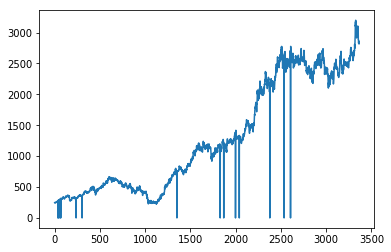

In [83]:
# -------------------- Data -------------------- #
def data_with_look_back(dataset):
    '''Returns x with look_back samples at time t and y with the sample at t+1 '''

    if len(dataset) < look_back:
        raise Exception("Dataset not large enough for given look back!")

    x, y = list(), list()
    for i in range(len(dataset) - look_back):
        x.append(dataset[i:look_back+i])
        y.append(dataset[look_back+i])
    
    return np.array(x), np.array(y)


# Get data
df = pd.read_csv(input_file, usecols=['timestamp', 'close'])
dataset = df['close'].astype('float32')
dataset = dataset[::-1]

if verbosity:
    print("Most recent data point at :", df['timestamp'][0], ":", dataset[len(dataset) - 1])
    print("Oldest data point at :", df['timestamp'][len(df['timestamp']) - 1], ":", dataset[0])

# Order data from oldest to newest
dataset = dataset.reshape((-1, 1))

plt.plot(dataset)
plt.show()

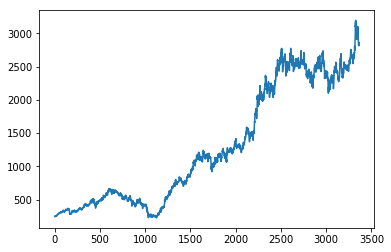

In [84]:
for i in range(len(dataset)):       # replace missing values with mean of prev and next
    if dataset[i] == 0:
        dataset[i] = np.mean([dataset[i-1], dataset[i+1]])

plt.plot(dataset)
plt.show()

In [85]:
# Normalize data
scaler = StandardScaler()
dataset = scaler.fit_transform(dataset)

if verbosity:
    print("Length of training set =", len(dataset))


train_x, train_y = data_with_look_back(dataset)
train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))

Length of training set = 3364


In [86]:
# -------------------- Model -------------------- #
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_x, train_y, epochs=250, batch_size=30, verbose=0)

trainPredict = model.predict(train_x)

In [87]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
train_y = scaler.inverse_transform(train_y)

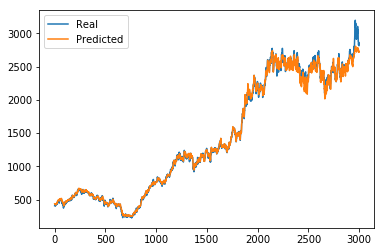

In [88]:
# Predicted Vs Original

plt.plot(train_y, label='Real')
plt.plot(trainPredict, label='Predicted')
plt.legend()
plt.show()

In [89]:
# calculate average error
trainScore = np.mean([math.fabs(x - y) for x, y in zip(train_y, trainPredict)])
print('Average Error in predictions: %.2f ' % (trainScore))
# calculate RMSE
trainScore = math.sqrt(np.mean([math.fabs(x - y)**2 for x, y in zip(train_y, trainPredict)]))
print('RMSE in predictions: %.2f ' % (trainScore))

Average Error in predictions: 25.84 
RMSE in predictions: 45.96 


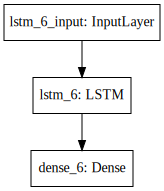

In [90]:
# -------------------- The Model -------------------- #

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

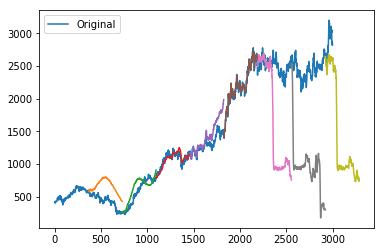

In [91]:
# Print direction of growth - take one batchSize, predict the next year's values
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'white']
c = 0
batchSize = 365
end = False
plt.plot(train_y, label='Original')
orig = scaler.transform(train_y)
orig.reshape(orig.shape[0])
for i in range(0, len(train_y)+1, batchSize):
    o = orig[i:i+look_back]
    #p = list(o[:])
    p = list()
    for j in range(batchSize):
        try:
            p.append(model.predict(o.reshape((1, 1, look_back)))[0])
        except:
            end = True
            break
        o = list(o[1:])
        o.append(p[-1])
        o = np.array(o)
    if end:
        break
    p = scaler.inverse_transform(p)
    plt.plot(range(i+batchSize, i+batchSize+len(p)), p)
    c += 1

orig = scaler.inverse_transform(orig)

plt.legend()
plt.savefig(input_file.split('/')[-1].split('.')[0] + '.png', format='png')
plt.show()

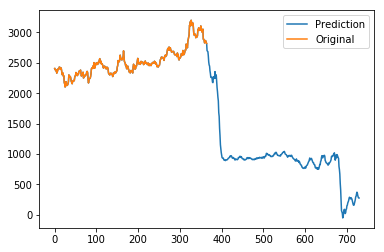

In [92]:
import copy
orig = scaler.transform(train_y)
o = orig[-365:]
p = list(o[:])
for i in range(365):
    p.append(model.predict(o.reshape((1, 1, look_back)))[0])
    o = list(o[1:])
    o.append(p[-1])
    o = np.array(o)
p = scaler.inverse_transform(p)
plt.plot(range(len(p)), p, label='Prediction')

o = scaler.inverse_transform(orig[-365:])
plt.plot(o, label='Original')
plt.legend()
plt.show()

In [93]:
in_a_month = p[364 + 30]
in_3_months = (p[364 + 120])
in_a_year = (p[-1])

print(in_a_month)
print(in_3_months)
print(in_a_year)

[1616.6664]
[934.6035]
[275.53455]


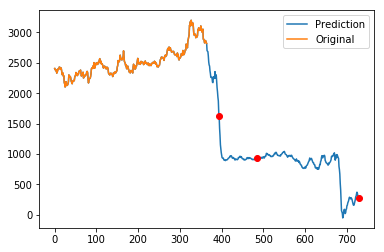

In [94]:
plt.plot(p, label='Prediction')
plt.plot(o, label='Original')
plt.legend()
plt.plot(364+30, in_a_month, 'ro')
plt.plot(364+120, in_3_months, 'ro')
plt.plot(364+365, in_a_year, 'ro')
plt.savefig('next' + input_file.split('/')[-1].split('.')[0] + '.png', format='png')
plt.show()

In [95]:
# Printing all predictions
for i in range(365, len(p)):
    print('+' + str(i-364), '\t', p[i])

+1 	 [2698.709]
+2 	 [2689.6921]
+3 	 [2681.5752]
+4 	 [2613.398]
+5 	 [2512.4707]
+6 	 [2464.211]
+7 	 [2446.4897]
+8 	 [2368.19]
+9 	 [2322.7627]
+10 	 [2259.8586]
+11 	 [2259.422]
+12 	 [2261.0334]
+13 	 [2244.8003]
+14 	 [2180.9854]
+15 	 [2173.0442]
+16 	 [2269.9106]
+17 	 [2237.703]
+18 	 [2259.0645]
+19 	 [2261.0967]
+20 	 [2354.4617]
+21 	 [2244.0999]
+22 	 [2278.3003]
+23 	 [2300.9019]
+24 	 [2185.0308]
+25 	 [2090.2002]
+26 	 [2022.4163]
+27 	 [1933.7034]
+28 	 [1872.3983]
+29 	 [1681.9967]
+30 	 [1616.6664]
+31 	 [1423.3356]
+32 	 [1303.5391]
+33 	 [1151.3911]
+34 	 [1076.7123]
+35 	 [1021.4635]
+36 	 [975.1488]
+37 	 [939.01]
+38 	 [934.212]
+39 	 [931.31287]
+40 	 [932.54285]
+41 	 [905.7543]
+42 	 [898.7167]
+43 	 [901.705]
+44 	 [896.1144]
+45 	 [891.459]
+46 	 [901.01855]
+47 	 [905.4397]
+48 	 [901.8745]
+49 	 [905.5115]
+50 	 [908.12964]
+51 	 [921.5621]
+52 	 [930.7229]
+53 	 [934.0808]
+54 	 [940.14435]
+55 	 [949.20105]
+56 	 [965.9133]
+57 	 [956.4455]
+58 	 [965.